<a href="https://colab.research.google.com/github/hamidriasat/Natural-Language-Processing/blob/master/Incident_Project_XLnet_with_summerizer_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  To get additional memory/ram
# a = []
# while(1):
    # a.append("1")

In [ ]:
!pip install pytorch-transformers


     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 8.7MB/s 
     |████████████████████████████████| 870kB 19.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=aaf5f96434086d060fb16aa654a66d26309c62baf8c69c54fe8936821f71ffea
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter


Using TensorFlow backend.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
!gdown --id 1H5YLUM-zsD7BbjMDO9iIJEjX5CQ-ols_

!unzip OverAllDataset

!gdown --id 1ynEhV2TlJ_Ga4rQ0LjbU_WZdVlPB48Kv

!unzip sentences


In [ ]:

def readLabels():
  full_labels= []
  with open( "OverAllDataset/Labels.txt" , encoding="cp1252") as content_file:
    for line in content_file:
      full_labels.append( int(line))
  return full_labels

def readData( ):
    full_date= []
    for i in range(1, 1147):
        with open( "OverAllDataset/"+ str(i) + ".txt" , encoding="cp1252") as content_file:
            fileData= content_file.read()
            full_date.append(fileData )

    return full_date


data_X= readData()
data_Y= readLabels()

print(len(data_X))
print(len(data_Y))

1146
1146


In [ ]:
for k in range(999, 1005): 
  print(data_Y[k])


5
4
0
0
0
0


In [ ]:
# !pip install bert-extractive-summarizer


In [ ]:
# from summarizer import Summarizer

# model = Summarizer()


In [ ]:
# sentences = []
# i=0 
# for doc_text in data_X:
#   print(i)
#   i+=1
#   sentences.append(model(doc_text , max_length= 300))


In [ ]:
def saveList(myList,filename):
    # the filename should mention the extension 'npy'
    np.save(filename,myList)
    print("Saved successfully!")

def loadList(filename):
    # the filename should mention the extension 'npy'
    tempNumpyArray=np.load(filename)
    return tempNumpyArray.tolist()

In [ ]:
# saveList(sentences,'sentences.npy')


In [ ]:
sentences=loadList('sentences.npy')

In [ ]:
print(data_X[5])
print("=============================")
print(sentences[5])


14 injured in wreck involving MARTA bus, 2 cars in SW Atlanta
Two people in one of the cars were taken to Grady Memorial Hospital with non-life-threatening injuries, police said. On the bus, 12 passengers complained of neck and back pain and are being treated at the scene by Atlanta Fire and Rescue Department paramedics.

14 injured in wreck involving MARTA bus, 2 cars in SW Atlanta
Two people in one of the cars were taken to Grady Memorial Hospital with non-life-threatening injuries, police said.


In [ ]:
labels = data_Y


In [ ]:
#  get number of occurrences for each element
Counter( data_Y )

Counter({0: 233, 1: 299, 2: 126, 3: 235, 4: 185, 5: 68})

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]


In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)

100%|██████████| 798011/798011 [00:00<00:00, 877738.81B/s]


In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁driver', '▁dead', '▁after', '▁crash', '▁with', '▁', 'georgia', '▁school', '▁bus', '▁carrying', '▁kids', '▁', 'g', 'win', 'nett', '▁county', ',', '▁', 'ga', '.', '▁', '-', '-', '▁police', '▁in', '▁', 'georgia', '▁say', '▁the', '▁driver', '▁of', '▁an', '▁', 's', 'uv', '▁has', '▁been', '▁killed', '▁in', '▁a', '▁crash', '▁with', '▁a', '▁bus', '▁carrying', '▁five', '▁elementary', '▁school', '▁students', '.', '▁news', '▁outlets', '▁reported', '▁the', '▁', 's', 'uv', '▁crashed', '▁into', '▁the', '▁', 'g', 'win', 'nett', '▁county', '▁bus', '▁just', '▁after', '▁3', '▁p', '.', 'm', '.', '▁at', '▁an', '▁intersection', '▁about', '▁40', '▁miles', '▁northeast', '▁of', '▁at', 'lan', 'ta', '▁in', '▁', 'bu', 'ford', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 300

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, 
# the authors recommend a batch size of 32, 48, or 128.
#  We will use 32 here to avoid memory issues.
batch_size = 16


# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=6)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=6)

model.cuda()

100%|██████████| 467042463/467042463 [00:36<00:00, 12789510.22B/s]


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.7402589177263195


Epoch:  25%|██▌       | 1/4 [01:00<03:01, 60.45s/it]

Validation Accuracy: 0.32083333333333336
Train loss: 1.6715075661396157


Epoch:  50%|█████     | 2/4 [02:00<02:00, 60.29s/it]

Validation Accuracy: 0.34861111111111115
Train loss: 1.321974640262538


Epoch:  75%|███████▌  | 3/4 [03:00<01:00, 60.19s/it]

Validation Accuracy: 0.5055555555555555
Train loss: 1.0926963430026482


Epoch: 100%|██████████| 4/4 [04:00<00:00, 60.11s/it]

Validation Accuracy: 0.5638888888888889


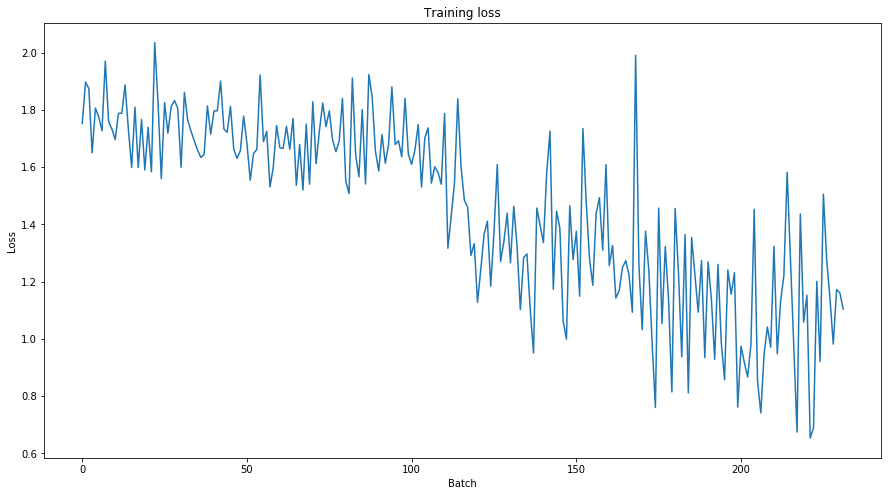

In [ ]:
# Let’s take a look at our training loss over all batches:

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()